In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [3]:
import time
import gc
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

from lmmnn.nn import reg_nn_ohe_or_ignore, reg_nn_embed, reg_nn_lmm
from lmmnn.simulation import Count

import tensorflow.keras.backend as K

In [37]:
file_path = 'nonlin-3_levels_s12345'

In [38]:
all_data = pd.read_csv('../Data/' + file_path + '.csv')
print(all_data.shape)
all_data.head()

(2000, 10)


,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Time,Group,Group_2,True_p,Response
0,0.859232,0.284951,0.636700,-0.232303,0.890744,1,1,2,0.989245,1
1,-0.367249,0.434907,0.000446,-0.369008,0.066464,2,1,2,0.984000,1
2,-0.632162,-0.064802,0.620379,0.136788,-0.495015,3,1,2,0.673735,1
3,-0.590879,-0.348831,-0.808063,-0.624364,0.441724,4,1,2,0.954860,1
4,0.135450,-0.120711,-0.562100,-0.748317,-0.265122,5,1,2,0.536130,1


In [39]:
print(len(all_data['Group'].unique()))

100


In [40]:
n_cats_group = len(all_data['Group'].unique())
print(f'no. of groups: {n_cats_group}')

no. of groups: 100


In [41]:
all_data.rename(columns={'Group_2': 'z0'}, inplace=True)

In [42]:
batch = 100
epochs = 1000
patience = 10
mode = 'glmm'
n_sig2bs = 2
est_cors = []
n_neurons = [10, 3]
activation = 'relu'
dropout = []
spatial_embedded_neurons = []
qs = [n_cats_group]
dist_matrix = None
q_spatial = None
Z_non_linear = False
Z_embed_dim_pct = 10
n_sig2bs_spatial = 0
time2measure_dict = None
spatial_embed_neurons = None
resultion = None
verbose = True
log_params = False
idx = None

In [43]:
def reg_nn(X_train, X_test, y_train, y_test, p_test, reg_type):
    start = time.time()
    if reg_type == 'lmm':
        y_pred, sigmas, _, _, n_epochs = reg_nn_lmm(
            X_train, X_test, y_train, y_test, qs, q_spatial, x_cols, batch, epochs, patience,
            n_neurons, dropout, activation, mode,
            n_sig2bs, n_sig2bs_spatial, est_cors, dist_matrix, spatial_embed_neurons, verbose, Z_non_linear, Z_embed_dim_pct, log_params, idx)
    # elif reg_type == 'ignore':
    #     y_pred, sigmas, _, _, n_epochs = reg_nn_ohe_or_ignore(
    #         X_train, X_test, y_train, y_test, qs, x_cols, batch, epochs, patience,
    #         n_neurons, dropout, activation, mode, n_sig2bs, n_sig2bs_spatial, est_cors, verbose, ignore_RE=True)
    # elif reg_type == 'embed':
    #     y_pred, sigmas, _, _, n_epochs = reg_nn_embed(
    #         X_train, X_test, y_train, y_test, qs, q_spatial, x_cols, batch, epochs, patience,
    #         n_neurons, dropout, activation, mode, n_sig2bs, n_sig2bs_spatial, est_cors, verbose)
    else:
        raise ValueError(reg_type + 'is an unknown reg_type')
    end = time.time()
    K.clear_session()
    gc.collect()
    # y_pred = np.clip(y_pred, 1, 10)
    mse = np.mean((y_pred - y_test)**2)
    mcr = [0] * 2000  # Create a list with 2000 elements initialized to 0
    for i in range(0,2000):
        np.random.seed(i)
        mcr[i] = np.mean((np.random.binomial(1, y_pred) - y_test)**2)
    # plt.scatter(y_test, y_pred, alpha=0.5)
    plt.scatter(p_test, y_pred, alpha=0.5)
    plt.show()
    # return mse, sigmas, n_epochs, end - start
    return mcr, y_pred

In [44]:
# kf = KFold(n_splits=3, shuffle=True, random_state=420)
X, y = all_data.drop(['True_p','Response', "Group"], axis=1), all_data['Response']
x_cols = [col for col in X.columns if col not in ['z0', 'z1', 'z2', 'Time']]

In [45]:
train_index = 17
X['z0'] = X['z0'] - 1

# Split X and y into train and test sets based on the 'Time' column
X_train = X[X['Time'] <= train_index]
X_test = X[X['Time'] > train_index]
y_train = y[X['Time'] <= train_index]
y_test = y[X['Time'] > train_index]

X_train = X_train.drop(['Time'], axis=1)
X_test = X_test.drop(['Time'], axis=1)

test = all_data[X['Time'] > train_index]
p_test = test['True_p']

In [46]:
X_test

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,z0
17,0.744352,-0.896085,-0.245310,0.585601,0.652761,1
18,0.929295,0.790179,0.697203,-0.009655,0.796201,1
19,0.447371,0.456532,0.822194,0.830187,-0.914569,1
37,0.026413,0.817950,0.909469,0.735918,-0.086261,2
38,0.364713,0.578757,-0.895493,0.911533,-0.500146,2
...,...,...,...,...,...,...
1978,0.991575,0.386547,-0.146472,0.758700,-0.746250,4
1979,-0.701523,-0.347573,0.792191,0.546423,-0.776418,4
1997,-0.923759,0.704097,0.672245,-0.632841,-0.961869,0
1998,-0.198908,-0.786962,0.980014,-0.900834,-0.481076,0


In [47]:
y_test

17      1
18      1
19      1
37      1
38      1
       ..
1978    1
1979    1
1997    0
1998    0
1999    1
Name: Response, Length: 300, dtype: int64

Epoch 1/1000
16/16 [==============================] - 0s 21ms/step - loss: 66.5822 - val_loss: 61.6016
Epoch 2/1000
16/16 [==============================] - 0s 3ms/step - loss: 65.3699 - val_loss: 60.7213
Epoch 3/1000
16/16 [==============================] - 0s 3ms/step - loss: 64.3380 - val_loss: 60.0177
Epoch 4/1000
16/16 [==============================] - 0s 3ms/step - loss: 63.4317 - val_loss: 59.4216
Epoch 5/1000
16/16 [==============================] - 0s 3ms/step - loss: 62.6216 - val_loss: 58.9283
Epoch 6/1000
16/16 [==============================] - 0s 3ms/step - loss: 61.8827 - val_loss: 58.5034
Epoch 7/1000
16/16 [==============================] - 0s 3ms/step - loss: 61.2000 - val_loss: 58.1155
Epoch 8/1000
16/16 [==============================] - 0s 3ms/step - loss: 60.5617 - val_loss: 57.7818
Epoch 9/1000
16/16 [==============================] - 0s 3ms/step - loss: 59.9548 - val_loss: 57.5122
Epoch 10/1000
16/16 [==============================] - 0s 3ms/step - loss: 59.390

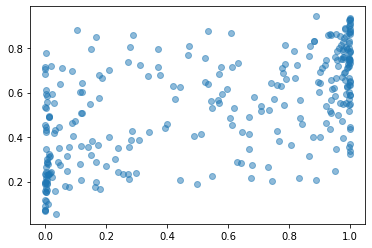

In [48]:
random.seed(42)
mcr, y_pred = reg_nn(X_train, X_test, y_train, y_test, p_test, reg_type='lmm')

In [49]:
np.mean(mcr)

0.3808

In [50]:
np.var(mcr)*10000

6.522155555555557

In [51]:
p_data_df = pd.DataFrame({'True_p': p_test.values, 'Predicted_p': y_pred})
p_data_df.to_csv('../Data/TrueAndPredictedTest/LMMNN' + file_path + '_group.csv')